# Exploratory Data Analysis

In [ ]:
# Imports

import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from transformers import pipeline
import seaborn as sns

# Load Data

In [ ]:
CSV_PATH = "data/data.csv"
df = pd.read_csv(CSV_PATH, dtype={'Unamed: 0': str, 'text': str, 'generated': int, 'source': str, 'attack': str})

In [5]:
df.head()

,Unnamed: 0,text,generated,source,attack
0,0,"Once upon a time, there was a lost island some...",1,mageset,NaN
1,1,Bring a sweater! They keep it coooold in here....,1,mageset,NaN
2,2,There were many religions practiced during the...,1,mageset,NaN
3,3,It would have been appreciated if the guy woul...,0,mageset,NaN
4,4,"According to the tradition, Virgil traveled to...",0,mageset,NaN


In [6]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [7]:
df['attack'].isna().sum()

np.int64(365000)

In [8]:
CONTRACTIONS = {
    # Negatives
    "can't": "can not",
    "cannot": "can not",
    "won't": "will not",
    "n't": " not",
    "ain't": "is not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "mustn't": "must not",
    "mightn't": "might not",

    # BE verbs
    "I'm": "I am",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "she's": "she is",
    "he's": "he is",
    "it's": "it is",
    "that's": "that is",
    "there's": "there is",
    "here's": "here is",

    # HAVE verbs
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "could've": "could have",
    "should've": "should have",
    "would've": "would have",
    "must've": "must have",
    "might've": "might have",

    # WILL verbs
    "I'll": "I will",
    "you'll": "you will",
    "we'll": "we will",
    "they'll": "they will",
    "he'll": "he will",
    "she'll": "she will",
    "it'll": "it will",
    "that'll": "that will",

    # WOULD verbs
    "I'd": "I would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "it'd": "it would",

    # ARE/AM/HAVE shortcuts
    "'re": " are",
    "'ve": " have",
    "'ll": " will",
    "'d": " would",
    "'m": " am",

    # Misc common contractions
    "y'all": "you all",
    "o'clock": "of the clock",
    "let's": "let us",
    "ma'am": "madam",
    "ne'er": "never",
    "shan't": "shall not",
    "who's": "who is",
    "who'd": "who would",
    "who'll": "who will",
    "what's": "what is",
    "what're": "what are",
    "what'll": "what will",
    "what've": "what have",
    "where's": "where is",
    "where'd": "where would",
    "where'll": "where will",
    "when's": "when is",
    "when'd": "when would",
    "why's": "why is",
    "why'd": "why would",
    "how's": "how is",
    "how'd": "how would",
    "how'll": "how will"
}

ai_favorite_words = {
    # Transition words (heavily overused)
    'furthermore', 'moreover', 'additionally', 'however', 'nevertheless',
    'nonetheless', 'consequently', 'therefore', 'thus', 'hence',
    'accordingly', 'subsequently', 'meanwhile', 'alternatively', 'conversely',
    'similarly', 'likewise', 'notably', 'importantly', 'significantly',
    'interestingly', 'remarkably', 'surprisingly', 'ultimately', 'fundamentally',

    # Hedging language
    'potentially', 'possibly', 'perhaps', 'arguably', 'seemingly',
    'apparently', 'presumably', 'conceivably', 'plausibly', 'ostensibly',

    # Emphasis words
    'crucial', 'vital', 'essential', 'critical', 'pivotal',
    'fundamental', 'paramount', 'imperative', 'significant', 'substantial',
    'considerable', 'notable', 'remarkable', 'profound', 'compelling',

    # Academic/formal words
    'comprehensive', 'extensive', 'thorough', 'meticulous', 'rigorous',
    'robust', 'nuanced', 'sophisticated', 'intricate', 'elaborate',
    'substantive', 'holistic', 'systematic', 'methodical', 'empirical',

    # Listing phrases
    'firstly', 'secondly', 'thirdly', 'lastly', 'finally',
    'initially', 'primarily', 'predominantly', 'chiefly', 'principally',

    # Cognitive verbs
    'delve', 'explore', 'examine', 'investigate', 'analyze',
    'scrutinize', 'evaluate', 'assess', 'consider', 'contemplate',
    'elucidate', 'illuminate', 'clarify', 'delineate', 'articulate',

    # Conclusion words
    'overall', 'altogether', 'collectively', 'cumulatively', 'comprehensively',
    'essentially', 'basically', 'fundamentally', 'inherently', 'intrinsically',

    # Certainty qualifiers
    'undoubtedly', 'unquestionably', 'indubitably', 'undeniably', 'certainly',
    'assuredly', 'definitively', 'categorically', 'unequivocally', 'indisputably',

    # Importance markers
    'noteworthy', 'salient', 'pertinent', 'relevant', 'germane',
    'applicable', 'apropos', 'material', 'consequential', 'momentous',

    # Causation words
    'facilitate', 'enable', 'precipitate', 'catalyze', 'engender',
    'foster', 'promote', 'advance', 'enhance', 'augment',
    'ameliorate', 'optimize', 'maximize', 'bolster', 'amplify',

    # Contrast markers
    'albeit', 'whereas', 'whilst', 'notwithstanding', 'despite',

    # Scope words
    'various', 'numerous', 'multiple', 'diverse', 'myriad',
    'multifaceted', 'multifarious', 'manifold', 'sundry', 'varied',

    # Impact words
    'implications', 'ramifications', 'repercussions', 'consequences', 'effects',
    'outcomes', 'results', 'findings', 'insights', 'observations',

    # Abstract concepts
    'paradigm', 'framework', 'methodology', 'approach', 'perspective',
    'context', 'narrative', 'discourse', 'rhetoric', 'dynamics',

    # Relationship words
    'correlate', 'correspond', 'align', 'resonate', 'parallel',
    'juxtapose', 'contrast', 'complement', 'supplement', 'reinforce',

    # Process words
    'utilize', 'implement', 'employ', 'deploy', 'leverage',
    'harness', 'capitalize', 'incorporate', 'integrate', 'synthesize',

    # Evaluation words
    'advantageous', 'beneficial', 'favorable', 'optimal', 'ideal',
    'preferable', 'superior', 'inferior', 'suboptimal', 'inadequate',

    # Vague intensifiers
    'highly', 'extremely', 'particularly', 'especially', 'exceedingly',
    'exceptionally', 'remarkably', 'substantially', 'considerably', 'vastly',

    # Summary phrases
    'in conclusion', 'in summary', 'to summarize', 'in essence', 'essentially',
    'all things considered', 'taken together', 'on balance', 'in totality',

    # Formal connectors
    'insofar', 'inasmuch', 'whereby', 'wherein', 'thereof',
    'therein', 'thereafter', 'heretofore', 'henceforth', 'herewith',

    # Probability words
    'likelihood', 'probability', 'possibility', 'propensity', 'tendency',
    'inclination', 'predisposition', 'susceptibility', 'proclivity', 'aptitude',

    # Meta-discourse
    'aforementioned', 'abovementioned', 'undermentioned', 'foregoing', 'preceding',
    'subsequent', 'ensuing', 'forthcoming', 'prospective', 'anticipated',

    # Business/tech jargon that AI loves
    'leverage', 'synergy', 'optimize', 'streamline', 'innovative',
    'cutting-edge', 'state-of-the-art', 'revolutionary', 'groundbreaking', 'pioneering',
    'transform', 'disrupt', 'revolutionize', 'spearhead', 'champion',

    # Explanation markers
    'specifically', 'namely', 'particularly', 'especially', 'explicitly',
    'precisely', 'exactly', 'distinctly', 'expressly', 'categorically',

    # AI's favorite adjectives
    'seamless', 'robust', 'elegant', 'sophisticated', 'comprehensive',
    'holistic', 'innovative', 'strategic', 'tactical', 'operational',

    # Certainty hedges
    'generally', 'typically', 'commonly', 'frequently', 'often',
    'usually', 'normally', 'ordinarily', 'customarily', 'habitually',

    # Formal emphasis
    'indeed', 'truly', 'verily', 'genuinely', 'authentically',
    'veritably', 'decidedly', 'markedly', 'patently', 'manifestly'
}

# Additional set for phrases (AI loves these multi-word expressions)
ai_favorite_phrases = {
    'it is important to note',
    'it should be noted',
    'it is worth noting',
    'dive deep',
    'deep dive',
    'at the end of the day',
    'in todays world',
    'in the modern era',
    'in contemporary society',
    'from a broader perspective',
    'taking a step back',
    'zooming out',
    'drilling down',
    'double down',
    'lean into',
    'unpack this',
    'lets break this down',
    'key takeaway',
    'pain point',
    'touch base',
    'circle back',
    'move the needle',
    'shift the paradigm',
    'think outside the box',
    'low-hanging fruit',
    'win-win situation',
    'best practices',
    'lessons learned',
    'going forward',
    'at this juncture',
    'in the final analysis',
    'when all is said and done',
    'the fact of the matter',
    'for all intents and purposes',
    'in light of',
    'in lieu of',
    'with regard to',
    'in terms of',
    'as it pertains to',
    'vis-a-vis',
    'per se',
    'de facto',
    'ipso facto',
    'prima facie',
    'ceteris paribus',
    'mutatis mutandis'
}

slang_words = {
    # General slang
    'gonna', 'wanna', 'gotta', 'kinda', 'sorta', 'coulda', 'shoulda', 'woulda',
    'dunno', 'gimme', 'lemme', 'outta', 'cmon', 'cmere', 'gotcha', 'betcha',
    'aint', 'yall', 'innit', 'init', 'bout', 'cause', 'cuz', 'cos',

    # Internet slang
    'lol', 'lmao', 'rofl', 'lmfao', 'omg', 'wtf', 'omfg', 'smh', 'tbh',
    'imo', 'imho', 'iirc', 'btw', 'fyi', 'tl;dr', 'tldr',
    'yolo', 'fomo', 'icymi', 'idk', 'idc',
    'rn', 'irl', 'ngl', 'fr', 'frfr', 'ong', 'istg', 'stg',
    'nvm', 'nvmd', 'jk', 'js', 'ik', 'ikr', 'ily', 'ilysm', 'ty', 'tysm',
    'np', 'yw', 'wbu', 'hbu', 'wyd', 'hmu', 'dm', 'pm', 'tmi', 'goat',

    # Gen Z slang
    'slay', 'periodt', 'bussin', "bussin'", "sheesh", 'no cap', 'cap', 'bet',
    'fam', 'bruh', 'bro', 'sis', 'bestie', 'bae', 'boo', 'lowkey', 'highkey',
    'deadass', 'lit', 'fire', 'sick', 'dope', 'slaps', 'bops', 'vibes', 'vibe',
    'mood', 'stan', 'salty', 'thirsty', 'basic', 'extra', 'bougie',
    'flex', 'flexing', 'drip', 'fit', 'fresh', 'clean', 'heat', 'cop', 'copped',
    'sus', 'sketch', 'sketchy', 'shook', 'triggered', 'pressed', 'tight', 'mad',
    'gucci', 'chillin', 'chilling', 'hangry', 'snatched', 'thicc', 'woke', 'based',
    'cringe', 'cringey', 'poggers', 'pog', 'pepega', 'yeet', 'oof', 'rip',
    'sksksk', 'tea', 'spill', 'shade', 'throwing shade', 'receipts', 'cancelled',
    'ghosting', 'ghosted', 'shipping', 'ship', 'hits different', 'bussin', 'cheugy',

    # Millennial slang
    'adulting', 'binge', 'netflix', 'selfie', 'unfriend', 'photobomb', 'facepalm',
    'humblebrag', 'mansplain', 'hangry', 'JOMO', 'swerve', 'turnt', 'turnup',
    'totes', 'adorbs', 'cray', 'cray-cray', 'deets', 'feels', 'squad', 'tribe',

    # British/Australian slang
    'bloody', 'blimey', 'bollocks', 'bugger', 'cheeky', 'dodgy', 'knackered',
    'mate', 'pissed', 'quid', 'reckon', 'shite', 'wanker', 'arvo', 'brekkie',
    'servo', 'maccas', 'chockers', 'ripper', 'bonkers', 'mental', 'nutter',
    'barmy', 'daft', 'gobsmacked', 'gutted', 'jammy', 'naff', 'posh', 'skint'
}

# EMOTIONAL WORDS (Raw human emotion)
emotional_words = {
    # Strong positive emotions
    'love', 'loving', 'loved', 'adore', 'adorable', 'amazing', 'awesome',
    'fantastic', 'wonderful', 'incredible', 'fabulous', 'brilliant', 'excellent',
    'ecstatic', 'thrilled', 'pumped', 'stoked', 'psyched', 'hyped', 'excited',
    'happy', 'joy', 'joyful', 'blessed', 'grateful', 'thankful', 'relieved',
    'proud', 'elated', 'overjoyed', 'euphoric', 'blissful', 'cheerful', 'gleeful',

    # Strong negative emotions
    'hate', 'hating', 'hated', 'despise', 'loathe', 'detest', 'abhor', 'disgusting',
    'awful', 'terrible', 'horrible', 'dreadful', 'appalling', 'atrocious', 'vile',
    'angry', 'furious', 'enraged', 'livid', 'pissed', 'mad', 'upset', 'frustrated',
    'annoyed', 'irritated', 'aggravated', 'infuriated', 'outraged', 'incensed',
    'sad', 'depressed', 'miserable', 'heartbroken', 'devastated', 'crushed',
    'destroyed', 'shattered', 'gutted', 'distraught', 'despondent', 'hopeless',

    # Fear and anxiety
    'scared', 'frightened', 'terrified', 'petrified', 'horrified', 'afraid',
    'anxious', 'nervous', 'worried', 'stressed', 'panicked', 'freaking', 'freaked',
    'paranoid', 'uneasy', 'tense', 'on edge', 'jittery', 'shaky', 'trembling',

    # Surprise and shock
    'shocked', 'stunned', 'amazed', 'astonished', 'astounded', 'flabbergasted',
    'dumbfounded', 'speechless', 'mindblown', 'shook', 'wtf', 'holy shit',
    'omg', 'wow', 'whoa', 'damn', 'jesus', 'christ', 'god', 'lord',

    # Disgust
    'gross', 'disgusting', 'revolting', 'repulsive', 'nasty', 'icky', 'yucky',
    'eww', 'ew', 'ugh', 'bleh', 'yikes', 'cringe', 'blegh', 'puke', 'vomit',

    # Emphatic expressions
    'literally', 'seriously', 'honestly', 'genuinely', 'absolutely', 'totally',
    'completely', 'entirely', 'utterly', 'fucking', 'freaking', 'frigging',
    'bloody', 'damn', 'hell', 'hella', 'super', 'mega', 'ultra', 'insanely',
    'ridiculously', 'unbelievably', 'incredibly', 'extremely', 'so', 'sooo', 'soooo',

    # Casual emotional reactions
    'meh', 'eh', 'blah', 'whatever', 'ugh', 'sigh', 'hmm', 'huh', 'oh',
    'ah', 'aha', 'ooh', 'aww', 'awww', 'awwww', 'yayyy', 'yayy', 'woohoo',
    'yahoo', 'hurray', 'hooray', 'phew', 'whew', 'pfft', 'pssh', 'tsk',

    # Personal expressions
    'my god', 'my goodness', 'oh my', 'dear god', 'sweet jesus', 'holy cow',
    'holy moly', 'goodness gracious', 'for real', 'i swear', 'i cant even',
    'dying', 'dead', 'screaming', 'crying', 'sobbing', 'bawling', 'weeping'
}

# COMMON TYPOS AND MISSPELLINGS
typos_and_misspellings = {
    # Common typos
    'teh', 'hte', 'adn', 'nad', 'ahve', 'hvae', 'taht', 'htat', 'thta',
    'wiht', 'wtih', 'whit', 'tihs', 'htis', 'thsi', 'jsut', 'jstu', 'justs',
    'liek', 'leik', 'alot', 'abit', 'aswell', 'awhile', 'everytime', 'anymore',
    'eachother', 'atleast', 'infact', 'incase', 'afterall', 'nevermind', 'meantime',

    # Double letters
    'soo', 'sooo', 'soooo', 'tooo', 'toooo', 'reallly', 'realllly', 'reeeally',
    'pleeease', 'pleeeease', 'yesss', 'yessss', 'nooo', 'noooo', 'goood', 'baaad',
    'looove', 'loooove', 'haaate', 'sooorry', 'sorrrry', 'happpy', 'saddd',

    # Missing letters
    'dont', 'doesnt', 'didnt', 'wont', 'cant', 'shouldnt', 'wouldnt', 'couldnt',
    'havent', 'hasnt', 'hadnt', 'isnt', 'arent', 'wasnt', 'werent', 'aint',
    'im', 'ive', 'id', 'ill', 'its', 'thats', 'whats', 'heres', 'theres',
    'whos', 'wheres', 'whens', 'hows', 'whys', 'lets', 'dont', 'weve', 'youre',
    'theyre', 'youve', 'theyve', 'were', 'everythings', 'nothings', 'somethings',

    # Wrong spellings
    'definately', 'defiantly', 'seperate', 'occured', 'untill', 'wich', 'recieve',
    'beleive', 'belive', 'wierd', 'thier', 'freind', 'feild', 'finaly', 'realy',
    'truely', 'actualy', 'probaly', 'proably', 'basicly', 'definatly', 'litterally',
    'accross', 'goverment', 'enviroment', 'buisness', 'begining', 'stoping', 'runing',
    'writting', 'comming', 'dinning', 'occuring', 'refering', 'prefering', 'transfering',

    # Phonetic spellings
    'ur', 'u', 'r', 'b4', '2day', '2morrow', '2nite', 'l8r', 'gr8', 'm8',
    'w8', 'str8', 'h8', 'd8', 'cre8', 'appreci8', 'thx', 'thnx', 'thanx',
    'pls', 'plz', 'bcuz', 'bcz', 'b/c', 'w/', 'w/o', 'w/e', 'prolly', 'probs',

    # Autocorrect fails
    'duck', 'ducking', 'shut', 'shot', "he'll", 'shell', 'well', "we'll",
    'ill', "i'll", 'itll', "it'll", 'wont', "won't", 'dont', "don't",

    # Missing spaces
    'alittle', 'acouple', 'eachother', 'everyday', 'everyone', 'everything',
    'goodmorning', 'goodnight', 'goodluck', 'thankyou', 'yourwelcome', 'inbetween',
    'infront', 'ontop', 'underneath', 'outside', 'inside', 'upstairs', 'downstairs',

    # Extra spaces
    'every thing', 'any thing', 'some thing', 'no thing', 'every one', 'any one',
    'some one', 'no one', 'every where', 'any where', 'some where', 'no where',

    # Number/letter substitutions
    '1st', '2nd', '3rd', '4th', '5th', 'sum1', 'ne1', 'any1', 'every1',
    'b4', 'gr8', '2day', '2nite', '2moro', 'l8r', 'h8', 'w8', 'str8'
}

# INFORMAL CONTRACTIONS AND EXPRESSIONS
informal_expressions = {
    # Filler words
    'um', 'umm', 'ummm', 'uh', 'uhh', 'uhhh', 'er', 'err', 'errr', 'ah', 'ahh',
    'oh', 'ohh', 'ohhh', 'well', 'like', 'you know', 'i mean', 'kind of', 'sort of',
    'basically', 'actually', 'literally', 'honestly', 'seriously', 'obviously',

    # Casual phrases
    'tbh', 'ngl', 'imo', 'imho', 'fwiw', 'afaik', 'iirc', 'ianal', 'ymmv',
    'gonna be honest', 'not gonna lie', 'to be fair', 'just saying', 'just sayin',
    'real talk', 'straight up', 'for real', 'for reals', 'no joke', 'i kid you not',
    'swear to god', 'i swear', 'on god', 'on my life', 'cross my heart', 'pinky promise',

    # Casual transitions
    'anyways', 'anyhoo', 'anywho', 'so yeah', 'yeah so', 'but yeah', 'but like',
    'i guess', 'i suppose', 'i reckon', 'i figure', 'seems like', 'looks like',
    'sounds like', 'feels like', 'pretty much', 'more or less', 'give or take',

    # Intensifiers (casual)
    'super', 'mega', 'ultra', 'hella', 'mad', 'wicked', 'stupid', 'crazy',
    'insane', 'ridiculous', 'absolutely', 'totally', 'completely', 'so', 'very',
    'really', 'quite', 'pretty', 'kinda', 'sorta', 'somewhat', 'a bit', 'a little'
}




In [12]:
# Preprocessing

def expand_contractions(text: str) -> str:
    for c, e in CONTRACTIONS.items():
        text = re.sub(c, e, text, flags=re.IGNORECASE)
    return text

def basic_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    text = expand_contractions(text)
    return text

def text_basic_features(text_series: pd.Series) -> pd.DataFrame:
    df = pd.DataFrame()
    df["char_count"] = text_series.apply(len)
    df["word_count"] = text_series.apply(lambda s: len(s.split()))
    df["avg_word_len"] = df["char_count"] / df["word_count"].replace(0, 1)
    df["num_sentences"] = text_series.apply(lambda s: max(1, s.count('.') + s.count('!') + s.count('?')))
    df["comma_count"] = text_series.apply(lambda s: s.count(','))
    df["exclamation_count"] = text_series.apply(lambda s: s.count('!'))
    df["question_count"] = text_series.apply(lambda s: s.count('?'))
    df["unique_word_count"] = text_series.apply(lambda s: len(set(s.split())))
    df["type_token_ratio"] = df["unique_word_count"] / df["word_count"].replace(0, 1)
    return df

# Data length

In [ ]:
len(df)

464000

# Count and percentage of human (0) vs AI (1) texts

In [ ]:
df['generated'].map({0: 'Human', 1: 'AI'}).value_counts()

,count
generated,
AI,232000
Human,232000


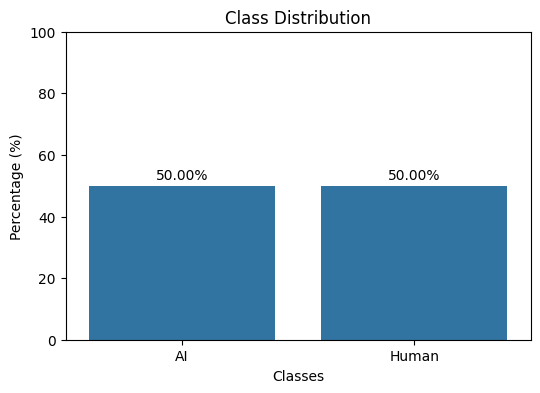

In [ ]:
class_weightages =  (df['generated'].map({0: 'Human', 1: 'AI'}).value_counts()/len(df))* 100

plt.figure(figsize=(6,4))
sns.barplot(x=class_weightages.index, y=class_weightages.values)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
for i, v in enumerate(class_weightages.values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

# Individual Dataset distribution


Text(0.5, 1.0, 'Dataset source distribution')

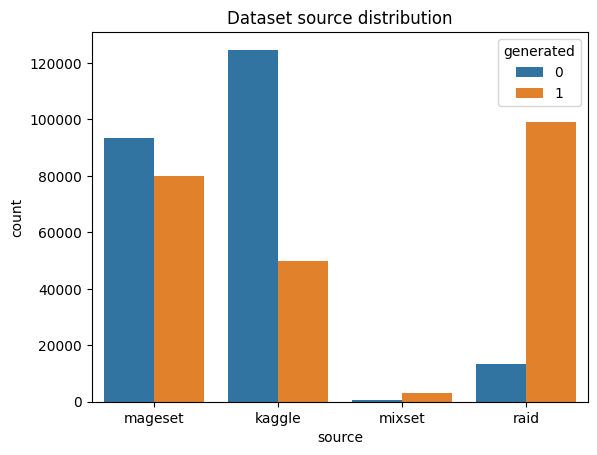

In [ ]:
sns.countplot(data=df, x='source', hue='generated')
plt.title("Dataset source distribution")

# Text length by class

Average length by class:
generated
0    1810.894905
1    1551.903638
Name: text_length, dtype: float64


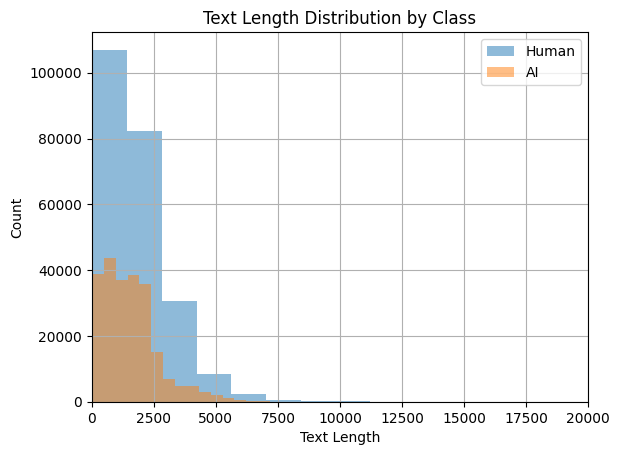

In [ ]:
# Check if data has length bias
df['text_length'] = df['text'].str.len()

print("Average length by class:")
print(df.groupby('generated')['text_length'].mean())

df[df['generated']==0]['text_length'].hist(alpha=0.5, label='Human', bins=50)
df[df['generated']==1]['text_length'].hist(alpha=0.5, label='AI', bins=50)
plt.legend()
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xlim(0,20000)
plt.title('Text Length Distribution by Class')
plt.show()

Text(0.5, 1.0, 'Text length counts of Human text in the Dataset')

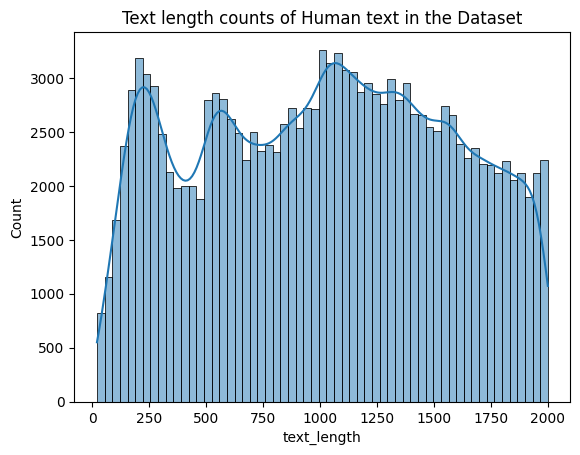

In [ ]:
sns.histplot(df[(df['generated']==0)&(df['text_length']<=2000)]['text_length'], kde=True)
plt.title('Text length counts of Human text in the Dataset')

Text(0.5, 1.0, 'Text length counts of AI text in the dataset')

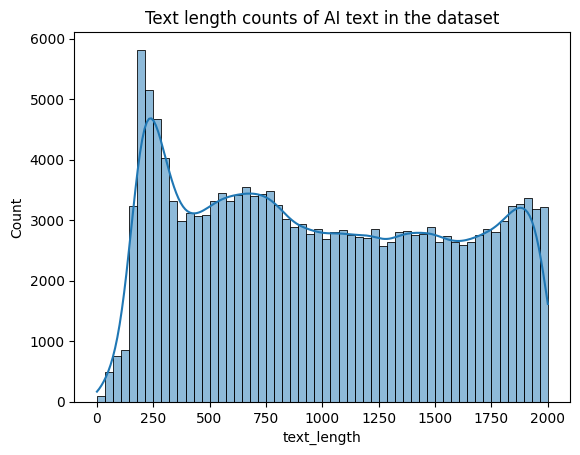

In [ ]:
sns.histplot(df[(df['generated']==1)&(df['text_length']<=2000)]['text_length'], kde=True)
plt.title('Text length counts of AI text in the dataset')

Text(0.5, 1.0, 'Text length counts of Human text with Kaggle as the source')

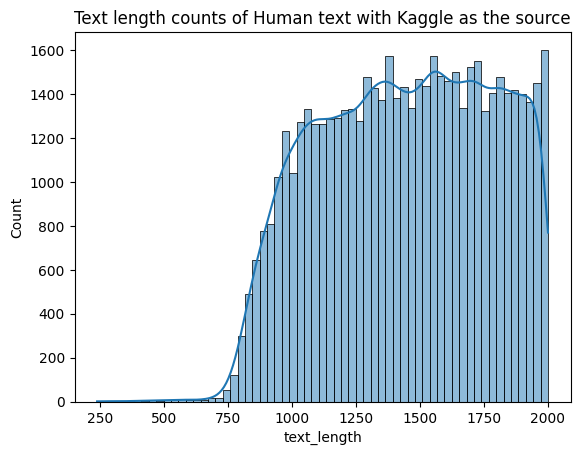

In [ ]:
sns.histplot(df[(df['generated']==0)&(df['text_length']<=2000)&(df['source']=='kaggle')]['text_length'], kde=True)
plt.title('Text length counts of Human text with Kaggle as the source')

Text(0.5, 1.0, 'Text length counts of Human text with Mageset as the source')

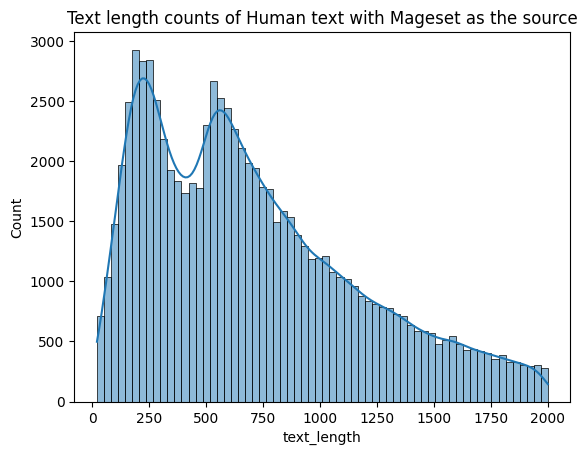

In [ ]:
sns.histplot(df[(df['generated']==0)&(df['text_length']<=2000)&(df['source']=='mageset')]['text_length'], kde=True)
plt.title('Text length counts of Human text with Mageset as the source')

Text(0.5, 1.0, 'Text length counts of AI text with Mageset as the source')

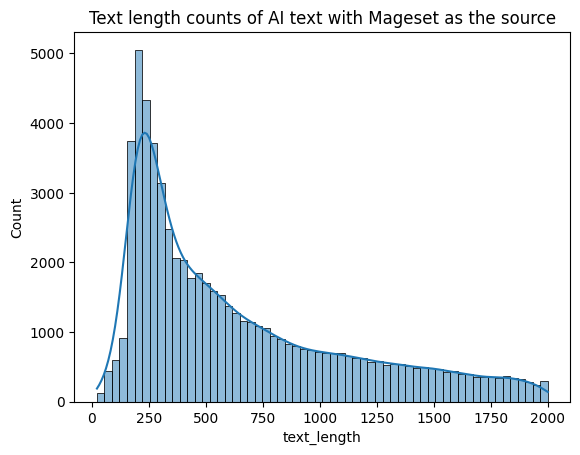

In [ ]:
sns.histplot(df[(df['generated']==1)&(df['text_length']<=2000)&(df['source']=='mageset')]['text_length'], kde=True)
plt.title('Text length counts of AI text with Mageset as the source')

Text(0.5, 1.0, 'Text length counts of AI text with RAID as the source')

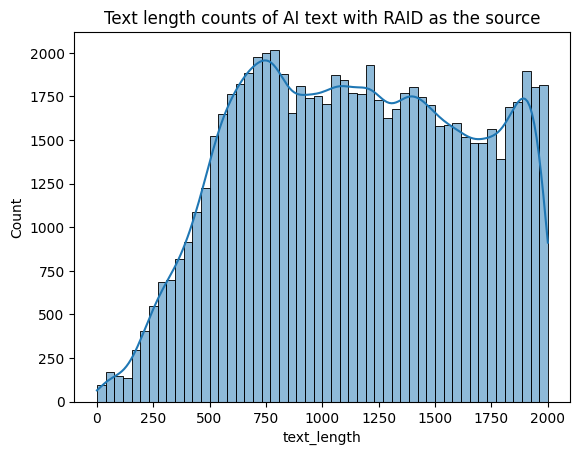

In [ ]:
sns.histplot(df[(df['generated']==1)&(df['text_length']<=2000)&(df['source']=='raid')]['text_length'], kde=True)
plt.title('Text length counts of AI text with RAID as the source')

# Attack distribution

In [ ]:
df.attack.fillna('No Attack', inplace=True)

/tmp/ipython-input-683062140.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.attack.fillna('No Attack', inplace=True)


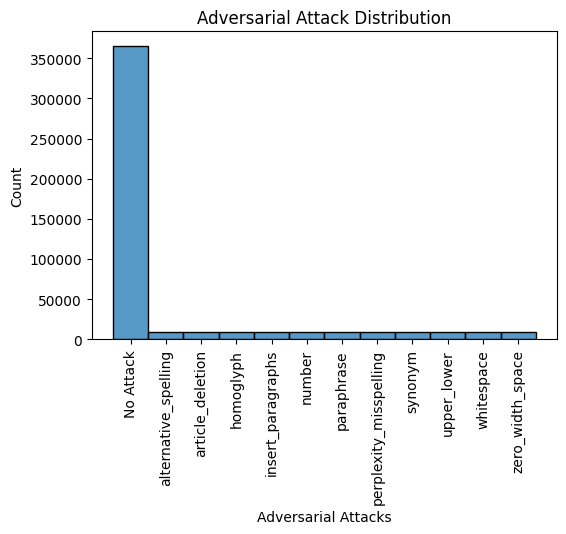

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(x=df.attack)
plt.title('Adversarial Attack Distribution')
plt.xlabel('Adversarial Attacks')
plt.ylabel('Count')
plt.xticks(rotation=90);

No attack type removed

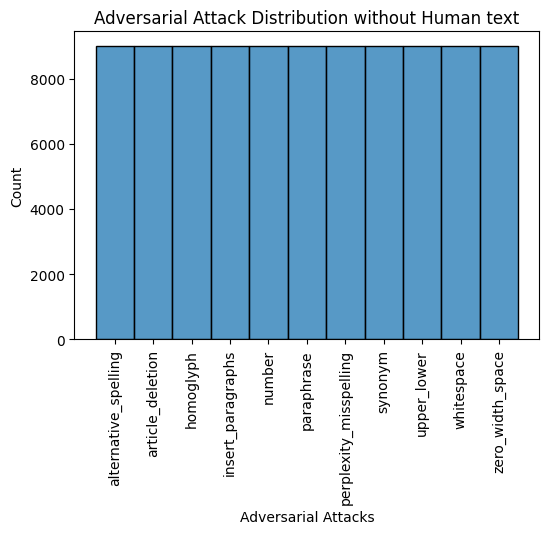

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(x=df[df.attack!='No Attack'].attack)
plt.title('Adversarial Attack Distribution without Human text')
plt.xlabel('Adversarial Attacks')
plt.ylabel('Count')
plt.xticks(rotation=90);

# Duplicates

In [ ]:
df['text'].duplicated().sum()

np.int64(5933)

# Missing values

In [ ]:
df.isna().sum()

text              0
generated         0
source            0
attack       365000
dtype: int64

# Sampling

In [13]:
sampled_df = train_test_split(df, train_size=int(len(df)*0.01), stratify=df['generated'], random_state=101)[0]

# Sampled Dataframe distribution

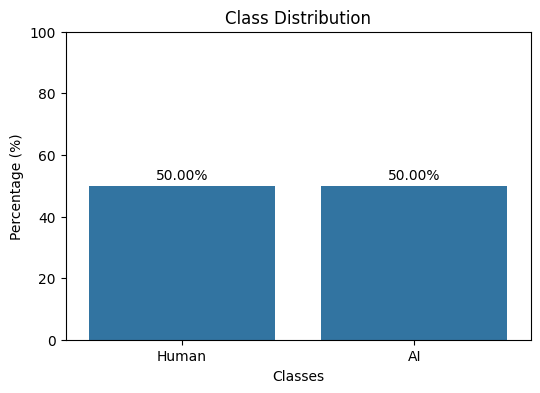

In [ ]:
class_weightages =  (sampled_df['generated'].map({0: 'Human', 1: 'AI'}).value_counts()/len(sampled_df))* 100

plt.figure(figsize=(6,4))
sns.barplot(x=class_weightages.index, y=class_weightages.values)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
for i, v in enumerate(class_weightages.values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

## Formality/tone of the texts

In [ ]:
formality_classifier = pipeline(
    "text-classification",
    model="s-nlp/roberta-base-formality-ranker"
)

def classify_formality(text):
    """Classify text as formal or casual"""
    try:
        result = formality_classifier(text[:512])  # Truncate for model limit
        label = result[0]['label']
        return 'formal' if 'formal' in label.lower() else 'casual'
    except:
        return 'unknown'

# Apply to dataset (may take time for large datasets)
sampled_df['formality'] = sampled_df['text'].apply(classify_formality)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
sampled_df['formality'].value_counts()

,count
formality,
formal,4639
unknown,1


Text(0, 0.5, 'counts')

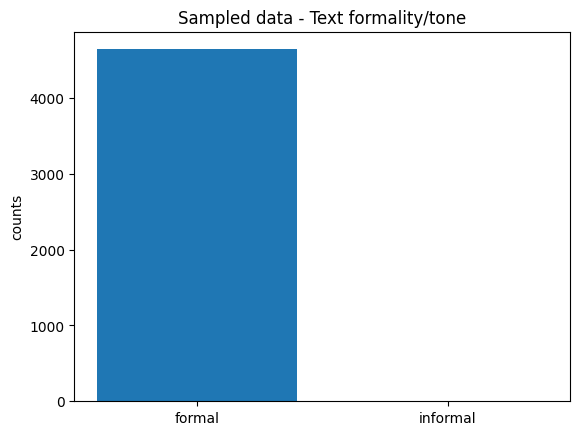

In [ ]:
sampled_df[sampled_df['formality']=='unknown']['formality']= 'informal'
sampled_df['formality'].value_counts().plot(kind='bar')
plt.title('Sampled data - Text formality/tone')

# Basic Preprocessing

In [14]:
sampled_df['text_cleaned'] = sampled_df['text'].apply(basic_clean)

# Classwise splits

In [15]:
ai_texts = sampled_df[sampled_df['generated'] == 1.0]['text_cleaned']
human_texts = sampled_df[sampled_df['generated'] == 0.0]['text_cleaned']

# Word Counts, classwise


In [16]:
ai_text_counts = Counter(" ".join(ai_texts.values).split())
human_text_counts = Counter(" ".join(human_texts.values).split())

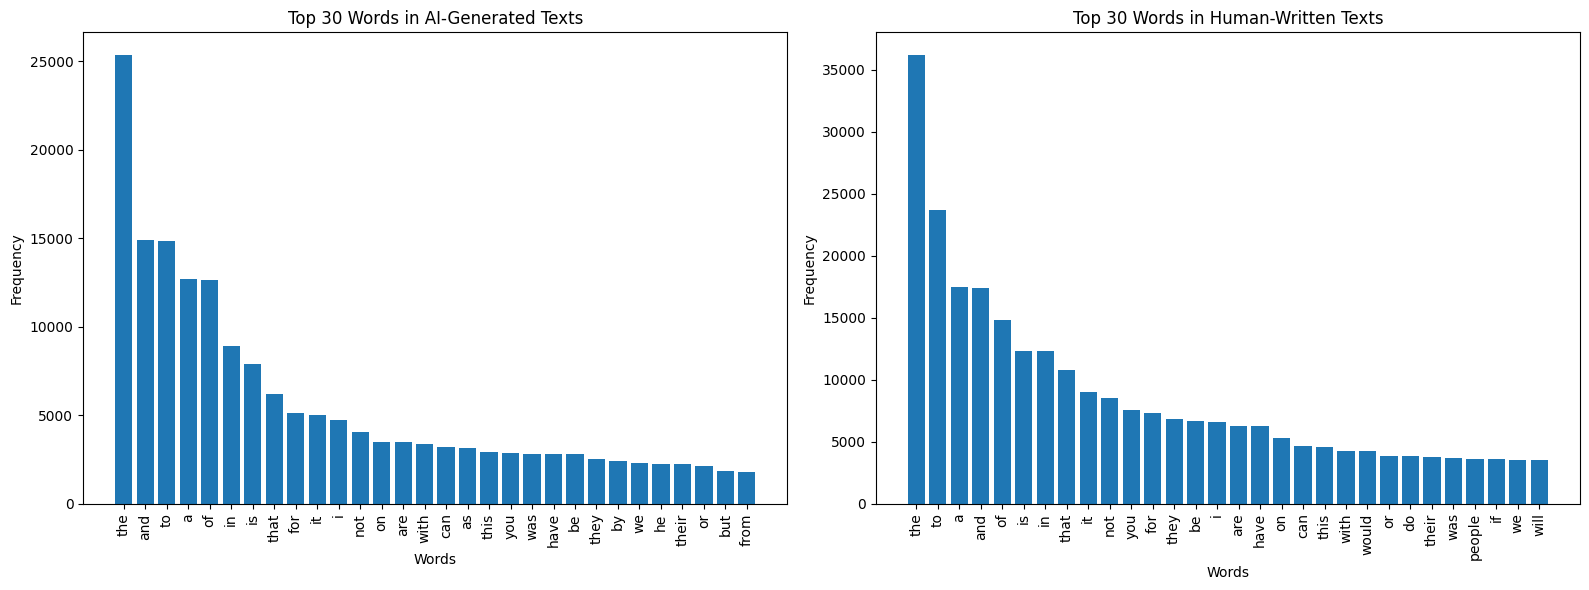

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*sorted(ai_text_counts.items(), key=lambda x: x[1], reverse=True)[:30]))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 30 Words in AI-Generated Texts")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*sorted(human_text_counts.items(), key=lambda x: x[1], reverse=True)[:30]))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 30 Words in Human-Written Texts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Unique words in AI text

In [ ]:
ai_unique_words = list(set(ai_text_counts.keys())-set(human_text_counts.keys()))
human_unique_words = list(set(human_text_counts.keys())-set(ai_text_counts.keys()))
ai_unique_words_dict = {word: ai_text_counts[word] for word in ai_unique_words}
human_unique_words_dict = {word: human_text_counts[word] for word in human_unique_words}

ai_unique_words_dict = dict(sorted(ai_unique_words_dict.items(), key=lambda item: item[1], reverse=True))
human_unique_words_dict = dict(sorted(human_unique_words_dict.items(), key=lambda item: item[1], reverse=True))

In [ ]:
dict(sorted(ai_unique_words_dict.items(), key=lambda x: x[1], reverse=True)[:30])

{'\u200bt\u200bh\u200be\u200b': 1337,
 'thе': 913,
 '\u200ba\u200b': 795,
 '\u200ba\u200bn\u200bd\u200b': 780,
 '\u200bo\u200bf\u200b': 712,
 '\u200bt\u200bo\u200b': 646,
 'оf': 620,
 'аnd': 566,
 'а': 530,
 'tо': 520,
 '\u200b': 517,
 '\u200bi\u200bn\u200b': 444,
 '\u200bi\u200bs\u200b': 415,
 'іn': 343,
 'іs': 282,
 '\u200bt\u200bh\u200ba\u200bt\u200b': 261,
 'thаt': 225,
 '\u200bf\u200bo\u200br\u200b': 217,
 'wіth': 173,
 '\u200bi\u200bt\u200b': 172,
 "\u200bi\u200b'\u200bm\u200b": 170,
 'fоr': 166,
 '\u200bw\u200bi\u200bt\u200bh\u200b': 153,
 '\u200ba\u200bs\u200b': 147,
 '\u200bi\u200b': 145,
 '\u200bn\u200bo\u200bt\u200b': 137,
 'hіs': 133,
 'оn': 133,
 '\u200bo\u200bn\u200b': 123,
 '\u200bt\u200bh\u200bi\u200bs\u200b': 122}

# Top 30 unique words from AI and Human text

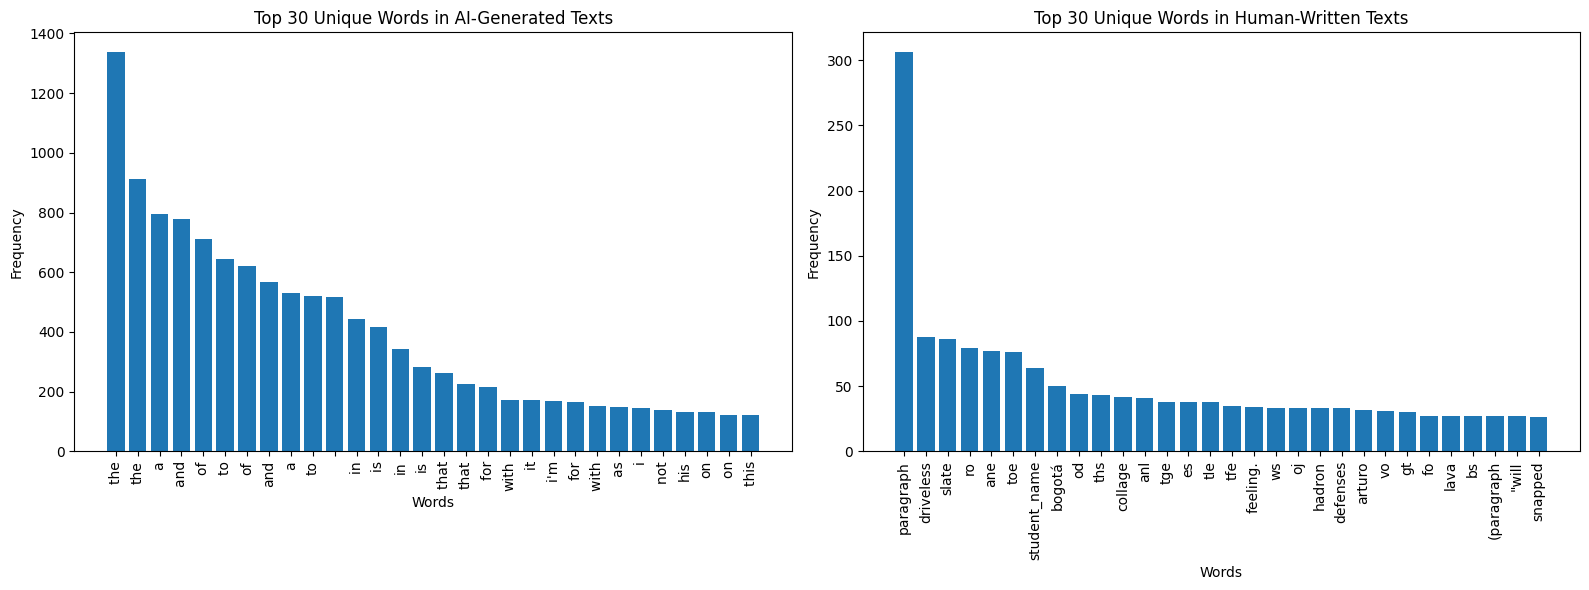

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*sorted(ai_unique_words_dict.items(), key=lambda x: x[1], reverse=True)[:30]))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 30 Unique Words in AI-Generated Texts")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*sorted(human_unique_words_dict.items(), key=lambda x: x[1], reverse=True)[:30]))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 30 Unique Words in Human-Written Texts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Above we see the word 'the' twice because its from a Homoglyphs attack record from the raid set

# Find emojis in AI and Human text

In [18]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F1E0-\U0001F1FF"
    "\U00002700-\U000027BF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA70-\U0001FAFF"
    "\U00002600-\U000026FF"
    "]+",
    flags=re.UNICODE,
)

emojis_in_ai_text = []
ai_texts.apply(lambda x: emojis_in_ai_text.extend(emoji_pattern.findall(x))).describe()

emojis_in_human_text = []
human_texts.apply(lambda x: emojis_in_human_text.extend(emoji_pattern.findall(x))).describe()


emoji_ai_counts = Counter(emojis_in_ai_text)
emoji_human_counts = Counter(emojis_in_human_text)

Human text from this dataset only contains 3 Emojis

In [19]:
emojis_in_human_text

['😕', '😭', '😂']

# Top 30 emojis used in AI and Human Text

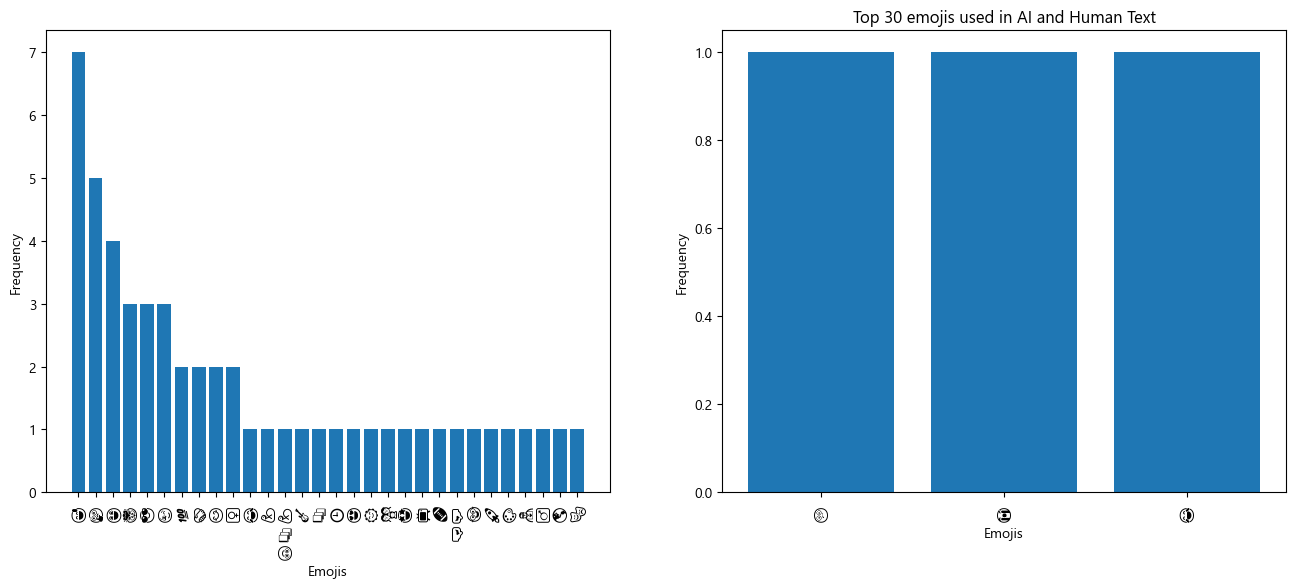

In [20]:
plt.rcParams['font.family'] = 'Segoe UI Emoji'
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*sorted(emoji_ai_counts.items(), key=lambda x: x[1], reverse=True)[:30]))
plt.xlabel("Emojis")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*sorted(emoji_human_counts.items(), key=lambda x: x[1], reverse=True)[:30]))
plt.xticks(rotation=90)
plt.xlabel("Emojis")
plt.ylabel("Frequency")
plt.title('Top 30 emojis used in AI and Human Text')
plt.show()

# Find words with special character

In [ ]:
pattern = re.compile(r"\b\w*[^\w\s]\w*\b")

words_with_special_characters_in_ai_text = []
ai_texts.apply(lambda x: words_with_special_characters_in_ai_text.extend(pattern.findall(x))).describe()

words_with_special_characters_in_human_text = []
human_texts.apply(lambda x: words_with_special_characters_in_human_text.extend(pattern.findall(x))).describe()
words_with_special_characters_in_ai_text = Counter(words_with_special_characters_in_ai_text)
words_with_special_characters_in_human_text = Counter(words_with_special_characters_in_human_text)

# Top 30 Words with Special Characters in AI and Human Texts

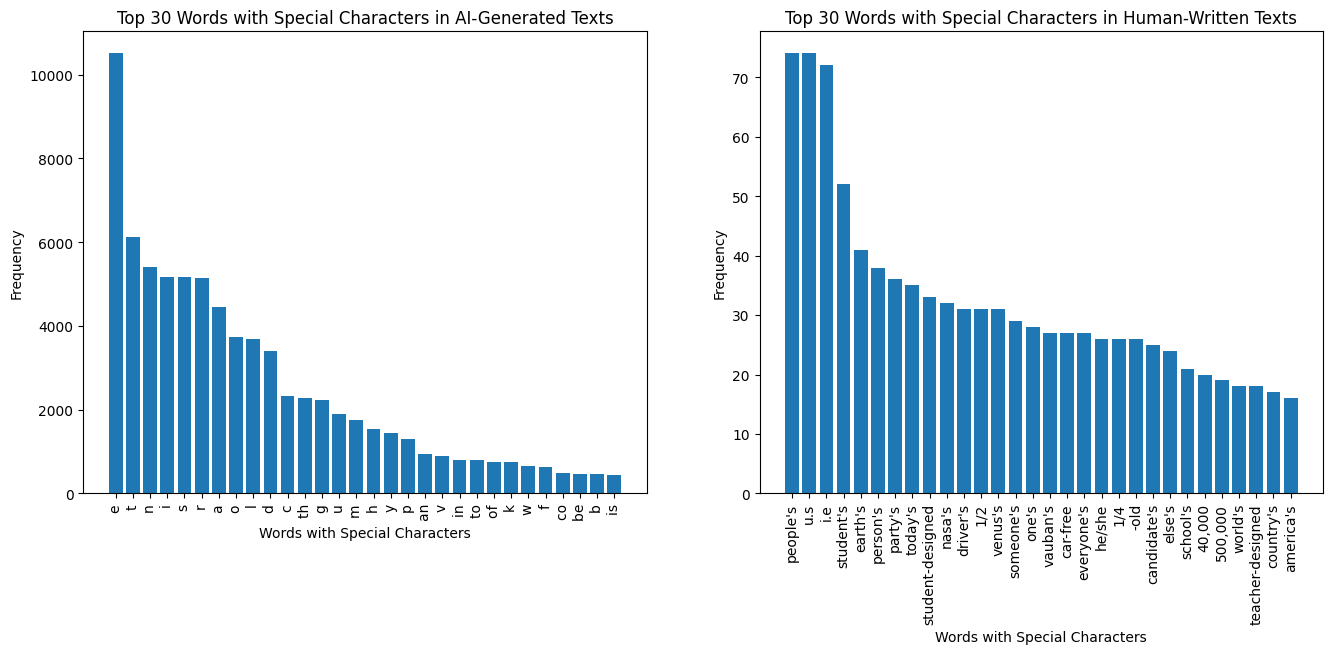

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*sorted(words_with_special_characters_in_ai_text.items(), key=lambda x: x[1], reverse=True)[:30]))
plt.xlabel("Words with Special Characters")
plt.ylabel("Frequency")
plt.title("Top 30 Words with Special Characters in AI-Generated Texts")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*sorted(words_with_special_characters_in_human_text.items(), key=lambda x: x[1], reverse=True)[:30]))
plt.xlabel("Words with Special Characters")
plt.ylabel("Frequency")
plt.title("Top 30 Words with Special Characters in Human-Written Texts")
plt.xticks(rotation=90)
plt.show();

# Find special characters in AI and Human text

In [ ]:
special_pattern = re.compile(
    r"[^A-Za-z0-9\s"           # not letters, digits, or whitespace
    r"\U0001F600-\U0001F64F"   # exclude emojis
    r"\U0001F300-\U0001F5FF"
    r"\U0001F680-\U0001F6FF"
    r"\U0001F1E0-\U0001F1FF"
    r"\U00002700-\U000027BF"
    r"\U0001F900-\U0001F9FF"
    r"\U0001FA70-\U0001FAFF"
    r"\U00002600-\U000026FF"
    r"]",
    flags=re.UNICODE,
)

special_characters_in_ai_text = []
ai_texts.apply(lambda x: special_characters_in_ai_text.extend(special_pattern.findall(x))).describe()

special_characters_in_human_text = []
human_texts.apply(lambda x: special_characters_in_human_text.extend(special_pattern.findall(x))).describe()

special_characters_ai_counts = Counter(special_characters_in_ai_text)
special_characters_human_counts = Counter(special_characters_in_human_text)

# Top 30 special characters used in AI and Human Text

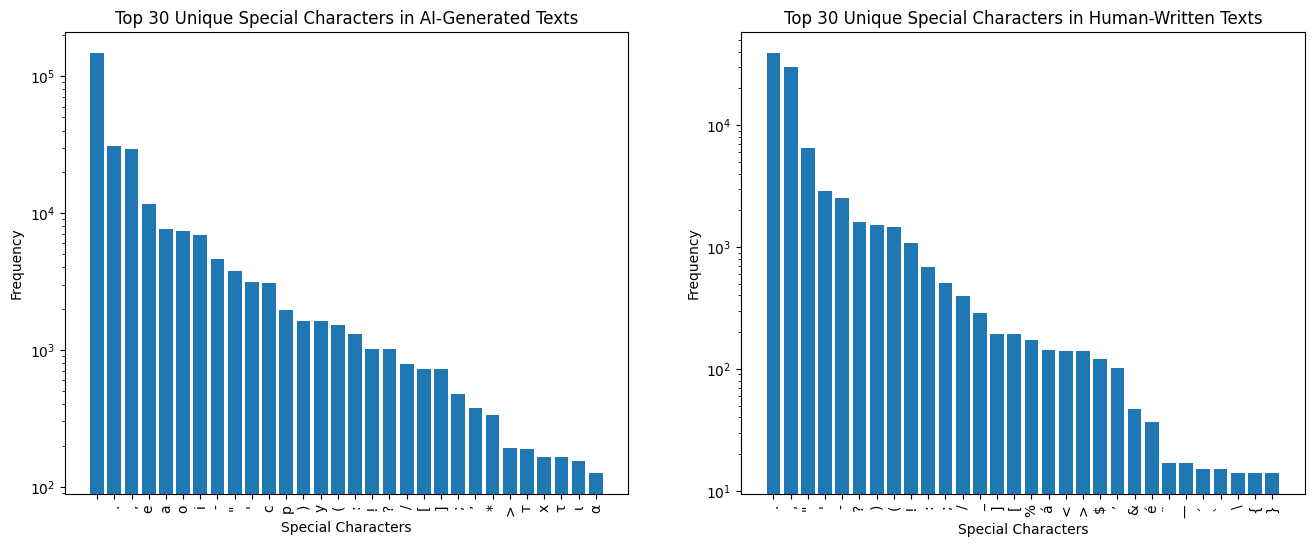

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*sorted(special_characters_ai_counts.items(), key=lambda x: x[1], reverse=True)[:30]))
plt.xlabel("Special Characters")
plt.ylabel("Frequency")
plt.yscale('log')
plt.title("Top 30 Unique Special Characters in AI-Generated Texts")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*sorted(special_characters_human_counts.items(), key=lambda x: x[1], reverse=True)[:30]))
plt.xlabel("Special Characters")
plt.ylabel("Frequency")
plt.title("Top 30 Unique Special Characters in Human-Written Texts")
plt.xticks(rotation=90)
plt.yscale('log')
plt.show();

# Sentence length distribution: AI

In [ ]:
ai_sentence_lengths = []
ai_texts.apply(lambda x: [ai_sentence_lengths.append(len(sentence.split(" "))) for sentence in re.split(r"[.!?]", x)]).describe()

human_sentence_lengths = []
human_texts.apply(lambda x: [human_sentence_lengths.append(len(sentence.split(" "))) for sentence in re.split(r"[.!?]", x)]).describe();

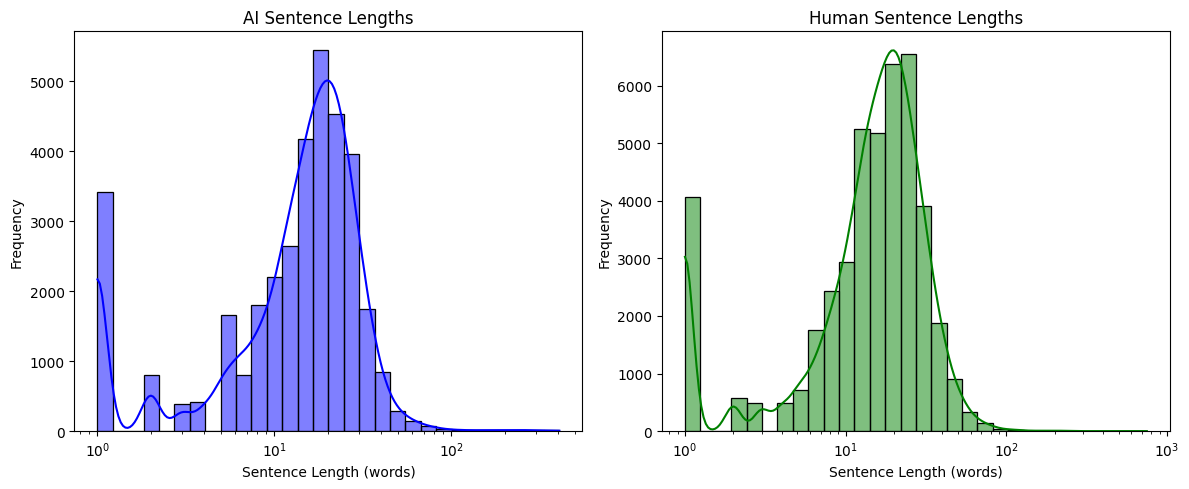

In [ ]:
plt.figure(figsize=(12, 5))

# ---- subplot 1 ----
plt.subplot(121)
sns.histplot(ai_sentence_lengths, bins=30, kde=True, color='blue', log_scale=(True, False))
plt.xlabel('Sentence Length (words)')
plt.ylabel('Frequency')
plt.title('AI Sentence Lengths')

# ---- subplot 2 ----
plt.subplot(122)
sns.histplot(human_sentence_lengths, bins=30, kde=True, color='green', log_scale=(True, False))
plt.xlabel('Sentence Length (words)')
plt.ylabel('Frequency')
plt.title('Human Sentence Lengths')

plt.tight_layout()
plt.show()

# Find AI Favorite word counts:

In [ ]:
ai_fav_word_counts_for_ai = {}
ai_fav_word_counts_for_human = {}
for fav_words in ai_favorite_words:
        ai_fav_word_counts_for_ai[fav_words] = ai_text_counts.get(fav_words, 0)
        ai_fav_word_counts_for_human[fav_words] = human_text_counts.get(fav_words, 0)

ai_fav_word_counts_for_ai = dict(sorted(ai_fav_word_counts_for_ai.items(), key=lambda x: x[1], reverse=True))
ai_fav_word_counts_for_human = dict(sorted(ai_fav_word_counts_for_human.items(), key=lambda x: x[1], reverse=True))

# Top 30 AI Favourite words found in AI and Human Texts

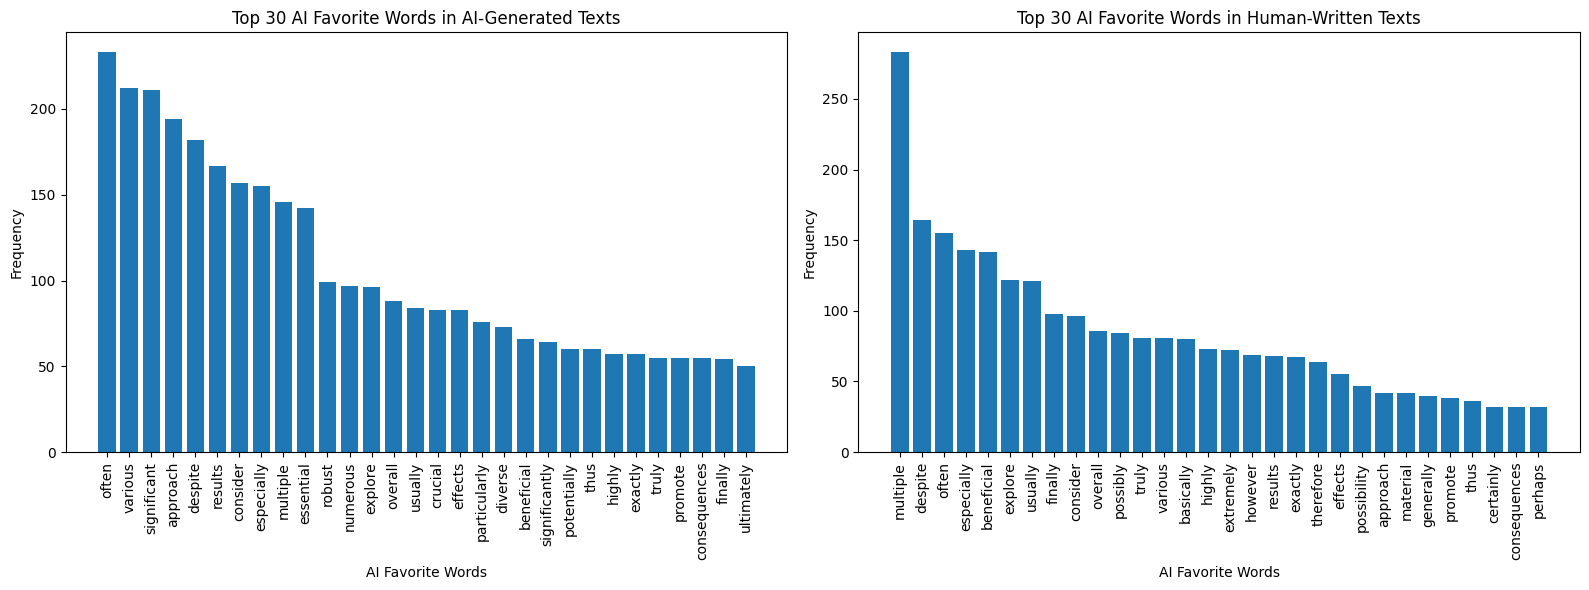

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*dict(list(ai_fav_word_counts_for_ai.items())[:30]).items()))
plt.xlabel("AI Favorite Words")
plt.ylabel("Frequency")
plt.title("Top 30 AI Favorite Words in AI-Generated Texts")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*dict(list(ai_fav_word_counts_for_human.items())[:30]).items()))
plt.xlabel("AI Favorite Words")
plt.ylabel("Frequency")
plt.title("Top 30 AI Favorite Words in Human-Written Texts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Find AI Favorite phrases counts:

In [ ]:
ai_fav_word_phrases_for_ai = {}
ai_fav_word_phrases_for_human = {}
for fav_phrases in ai_favorite_phrases:
    ai_fav_word_phrases_for_ai[fav_phrases] = sum(1 for text in ai_texts if fav_phrases in text)
    ai_fav_word_phrases_for_human[fav_phrases] = sum(1 for text in human_texts if fav_phrases in text)
ai_fav_word_phrases_for_ai = dict(sorted(ai_fav_word_phrases_for_ai.items(), key=lambda x: x[1], reverse=True))
ai_fav_word_phrases_for_human = dict(sorted(ai_fav_word_phrases_for_human.items(), key=lambda x: x[1], reverse=True))

# Top 30 AI Favourite phrases found in AI and Human Texts

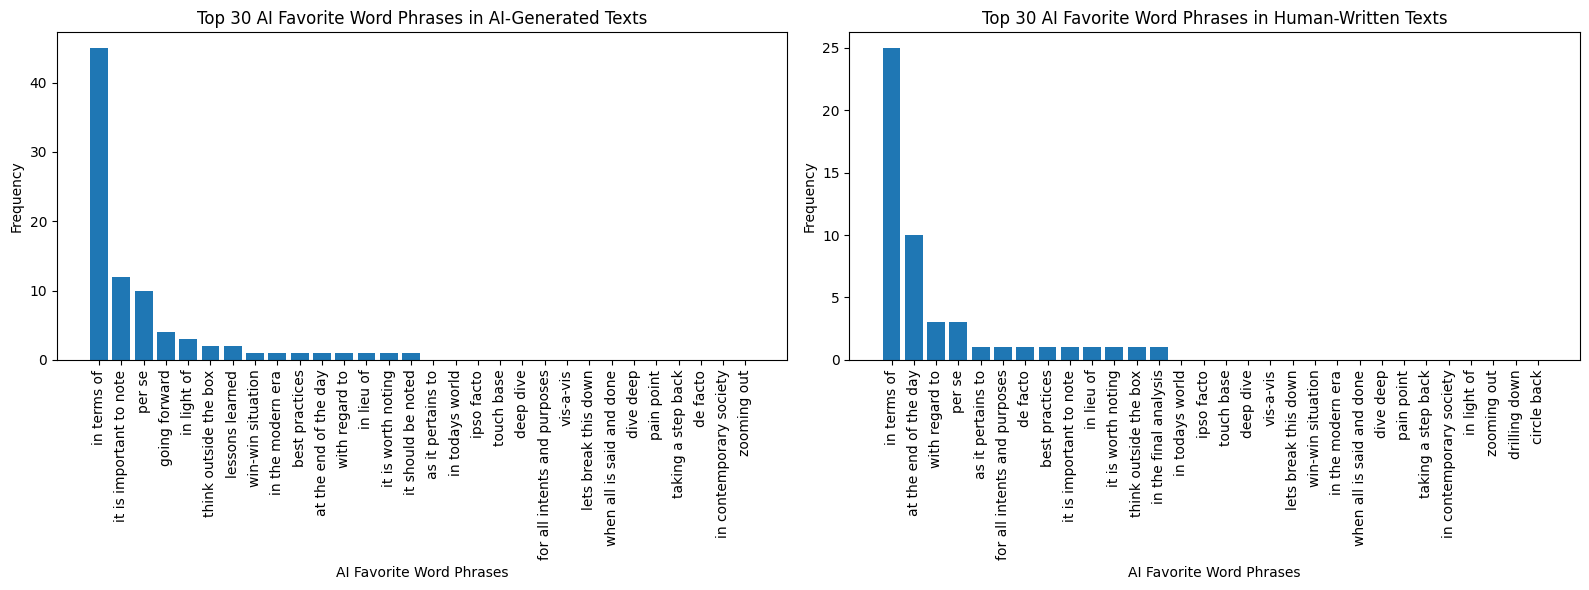

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*dict(list(ai_fav_word_phrases_for_ai.items())[:30]).items()))
plt.xlabel("AI Favorite Word Phrases")
plt.ylabel("Frequency")
plt.title("Top 30 AI Favorite Word Phrases in AI-Generated Texts")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*dict(list(ai_fav_word_phrases_for_human.items())[:30]).items()))
plt.xlabel("AI Favorite Word Phrases")
plt.ylabel("Frequency")
plt.title("Top 30 AI Favorite Word Phrases in Human-Written Texts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Find Human slang counts:

In [ ]:
ai_on_slang_words = {}
human_on_slang_words = {}
for slang in slang_words:
    ai_on_slang_words[slang] = ai_text_counts.get(slang, 0)
    human_on_slang_words[slang] = human_text_counts.get(slang, 0)
ai_on_slang_words = dict(sorted(ai_on_slang_words.items(), key=lambda x: x[1], reverse=True))
human_on_slang_words = dict(sorted(human_on_slang_words.items(), key=lambda x: x[1], reverse=True))

# Top 30 Human slang words found in AI and Human Texts

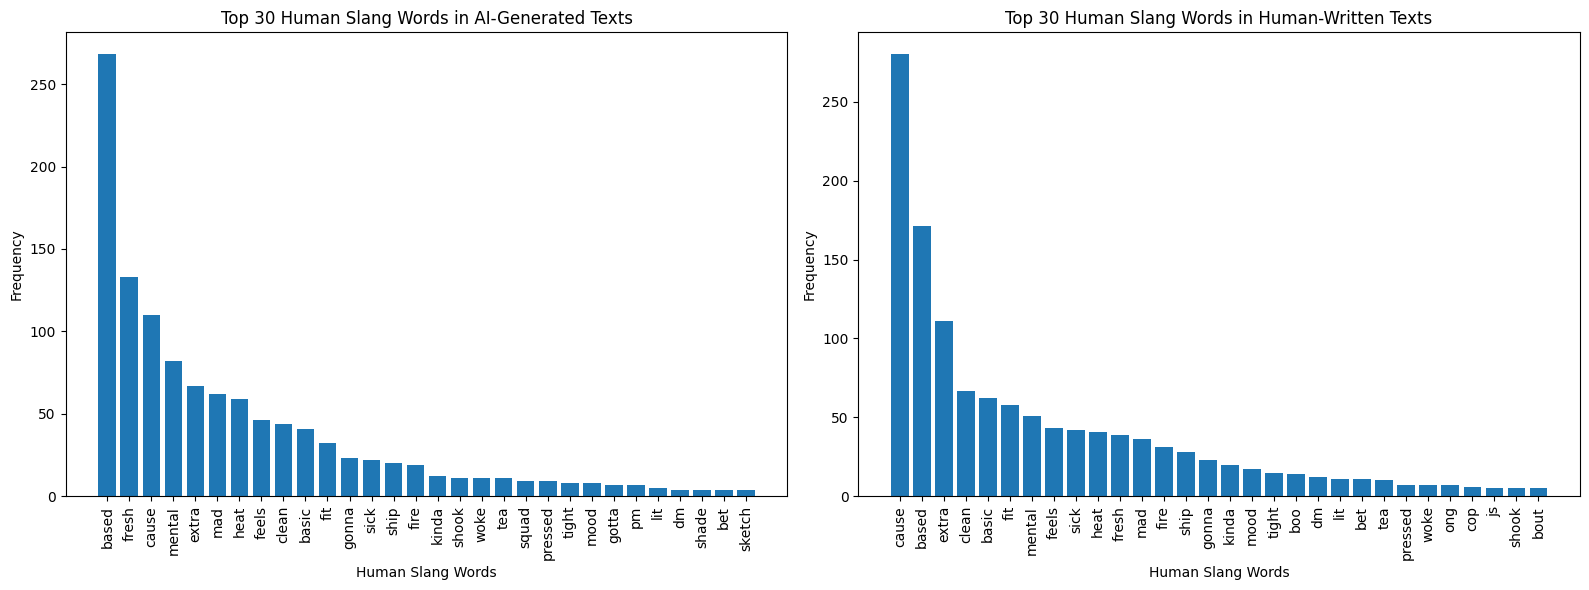

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*dict(list(ai_on_slang_words.items())[:30]).items()))
plt.xlabel("Human Slang Words")
plt.ylabel("Frequency")
plt.title("Top 30 Human Slang Words in AI-Generated Texts")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*dict(list(human_on_slang_words.items())[:30]).items()))
plt.xlabel("Human Slang Words")
plt.ylabel("Frequency")
plt.title("Top 30 Human Slang Words in Human-Written Texts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Find Human emotional words counts:

In [ ]:
ai_on_emotional_words = {}
human_on_emotional_words = {}

for emo_word in emotional_words:
        ai_on_emotional_words[emo_word] = ai_text_counts.get(emo_word, 0)
        human_on_emotional_words[emo_word] = human_text_counts.get(emo_word, 0)
ai_on_emotional_words = dict(sorted(ai_on_emotional_words.items(), key=lambda x: x[1], reverse=True))
human_on_emotional_words = dict(sorted(human_on_emotional_words.items(), key=lambda x: x[1], reverse=True))

# Top 30 Human emotional words found in AI and Human Texts

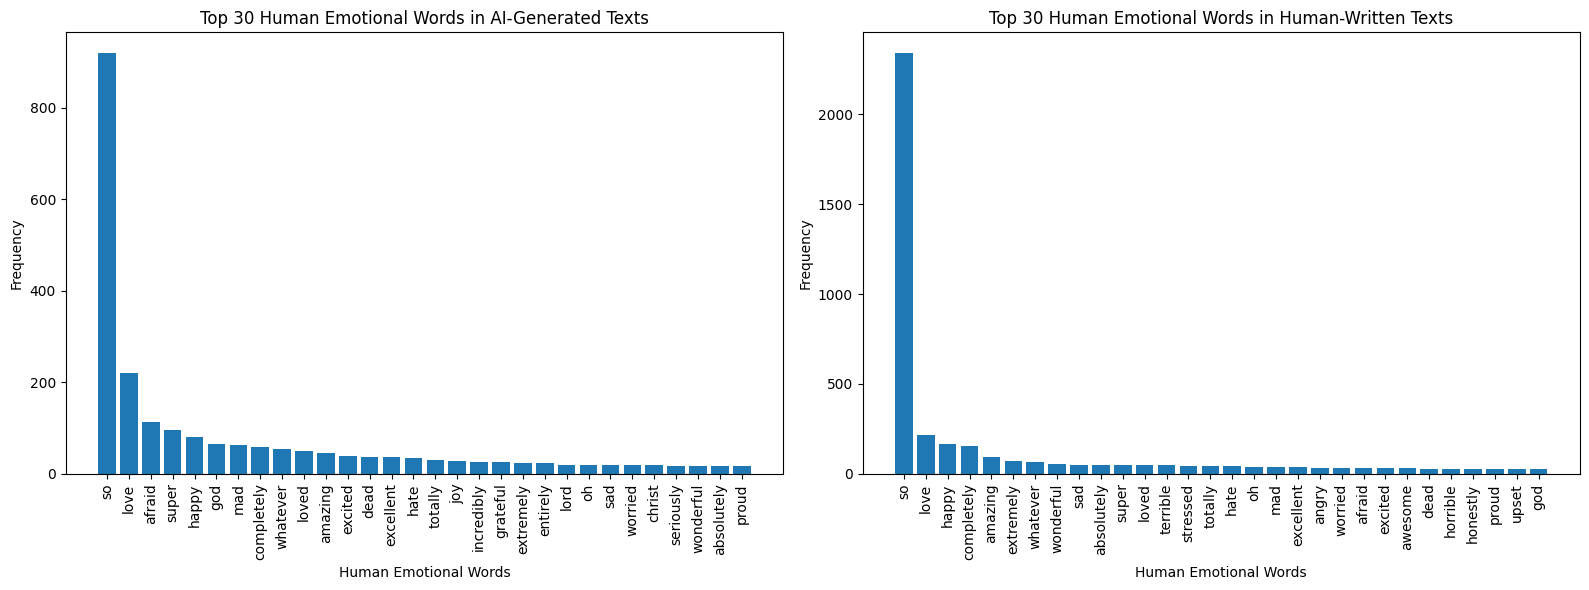

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*dict(list(ai_on_emotional_words.items())[:30]).items()))
plt.xlabel("Human Emotional Words")
plt.ylabel("Frequency")
plt.title("Top 30 Human Emotional Words in AI-Generated Texts")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*dict(list(human_on_emotional_words.items())[:30]).items()))
plt.xlabel("Human Emotional Words")
plt.ylabel("Frequency")
plt.title("Top 30 Human Emotional Words in Human-Written Texts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Find Typo words counts:

In [ ]:
ai_on_typos = {}
human_on_typos = {}

for typo in typos_and_misspellings:
        ai_on_typos[typo] = ai_text_counts.get(typo, 0)
        human_on_typos[typo] = human_text_counts.get(typo, 0)
ai_on_typos = dict(sorted(ai_on_typos.items(), key=lambda x: x[1], reverse=True))
human_on_typos = dict(sorted(human_on_typos.items(), key=lambda x: x[1], reverse=True))

# Top 30 typo words found in AI and Human Texts

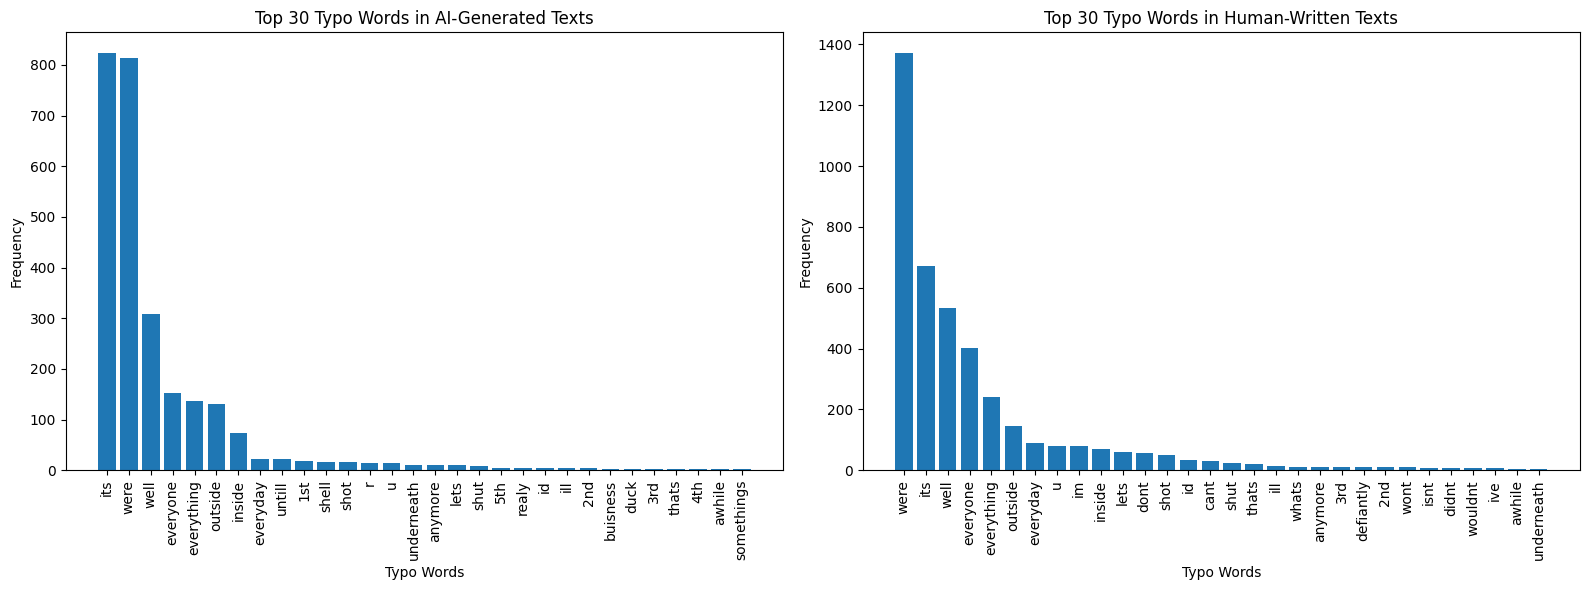

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*dict(list(ai_on_typos.items())[:30]).items()))
plt.xlabel("Typo Words")
plt.ylabel("Frequency")
plt.title("Top 30 Typo Words in AI-Generated Texts")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*dict(list(human_on_typos.items())[:30]).items()))
plt.xlabel("Typo Words")
plt.ylabel("Frequency")
plt.title("Top 30 Typo Words in Human-Written Texts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Find Informal expression words counts:

In [ ]:
ai_on_informal_expressions = {}
human_on_informal_expressions = {}

for inf_exp in informal_expressions:
        ai_on_informal_expressions[inf_exp] = ai_text_counts.get(inf_exp, 0)
        human_on_informal_expressions[inf_exp] = human_text_counts.get(inf_exp, 0)

ai_on_informal_expressions = dict(sorted(ai_on_informal_expressions.items(), key=lambda x: x[1], reverse=True))
human_on_informal_expressions = dict(sorted(human_on_informal_expressions.items(), key=lambda x: x[1], reverse=True))

# Top 30 Informal ecxpression words found in AI and Human Texts

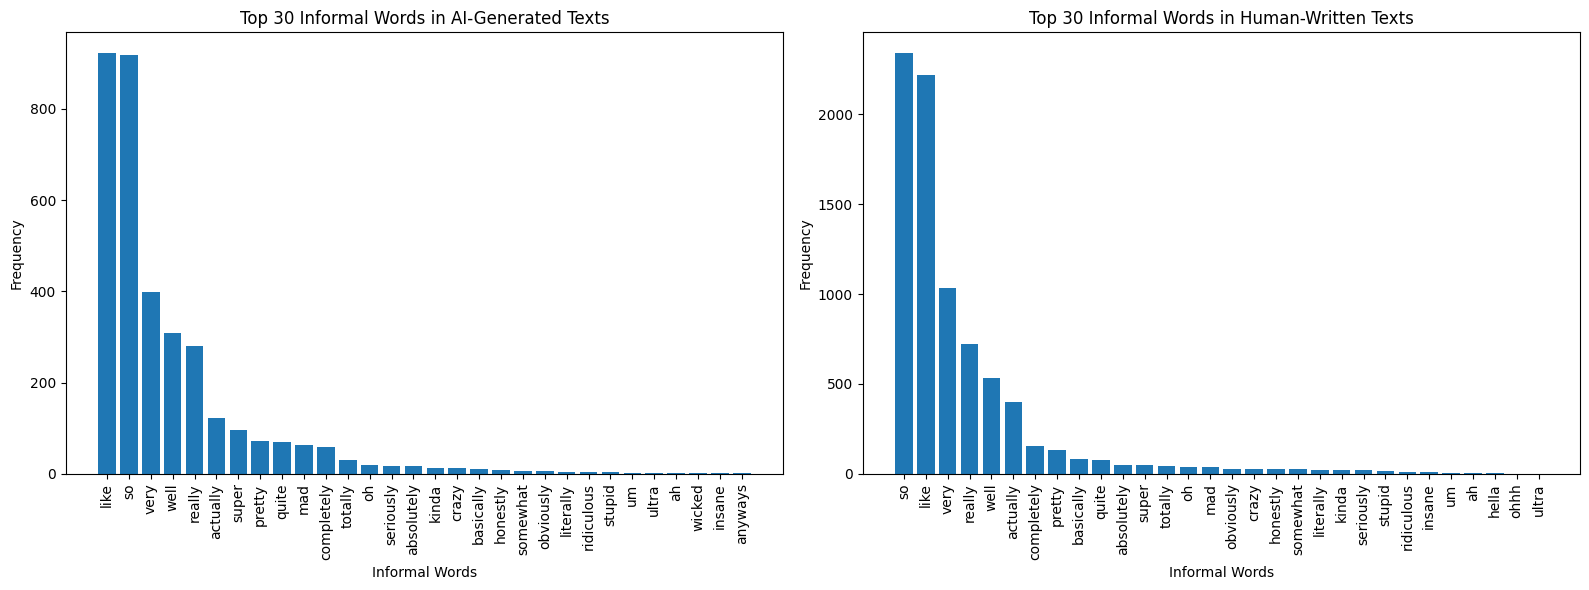

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.bar(*zip(*dict(list(ai_on_informal_expressions.items())[:30]).items()))
plt.xlabel("Informal Words")
plt.ylabel("Frequency")
plt.title("Top 30 Informal Words in AI-Generated Texts")
plt.xticks(rotation=90)
plt.subplot(122)
plt.bar(*zip(*dict(list(human_on_informal_expressions.items())[:30]).items()))
plt.xlabel("Informal Words")
plt.ylabel("Frequency")
plt.title("Top 30 Informal Words in Human-Written Texts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()